# Bayesian Inference 1: Project Report

### Title: "Ethnic and income segregation in Vyborg"

### Name: Antti Härkönen


## Abstract

> __

## Introduction

This project deals with the spatial segregation of ethnic groups in the city of Vyborg in 1880. At the time the city was
a part of Autonomous Grand Duchy of Finland, which was a part of the Russian Empire. The city had unusually diverse, but
mostly Lutheran, population. The members of the sizable Russian minority were mainly members Russian Orthodox church and
had a distinct identity, but little is known about how well they were integrated with the other population groups. One
important indicator of integration is spatial segregation. This can be studied using archival materials, but measuring
different kinds segregation is difficult. Obviously, there is some level of economic segregation, where the richer merchants
lived in the better parts of the town. Also, when the population of any minority group is affected by the same spatial
conditions as everyone, which means that the general population density has to be accounted for when studying the spatial
distributions of a minority group. My aim is to determine whether a hidden segregation variable can be inferred using
the existing data. In a regression context, this would mean studying whether or not the coefficient for the effect of
the hidden variable is around zero.

A Generalized linear model with Poisson distribution is used to model the size of Orthodox population in a location.
One of the variables used to predict number of Orthodox people is a hypothetical unobserved variable S, which stands for
segregation which is not caused by income differences. Other unobserved variables are the regression coefficients for the
Poisson regression.

Python libraries used in this project are the following:
* pymc3 for specifying Bayesian models
* geopandas for reading, manipulating and plotting geospatial data
* pandas and numpy for managing data
* matplotlib for scatter plots and histograms
* arviz for visualising results of Bayesian computations

The aim of this project is to learn about the graphical models that could be used for studying challenging statistical
inference problems. To my knowledge, there are no comparable studies of modeling high resolution spatial segregation that could be used as guidelines in

## Methods

### Dataset description and processing

A spatial dataset containing demographic and tax data from the city Vyborg in 1880 is used as data. The data is created
by combining data from following sources:
* Religious affiliation of inhabitants of each household is recorded in the poll tax register of 1880
* Paid income tax is recorded in the Income tax register of 1880
* Location of each city plot is determined using a variety of digitized, georeferenced and vectorized historical maps

These sources are combined using plot numbers found in each source and joining them with Python tools such as pandas and
geopandas. Since the data is 140 years old, modern regulations about storing personal information do not apply.

There are three columns that are relevant for current model in the dataset:
* total: Total number of inhabitants in location k
* orthodox: Total number of Eastern Orthodox inhabitants in location k
* income_per_person: Income per capita in location k

The number of orthodox people is proxy for ethnically Russian population, since well over 90 percent of Orthodox civilian
population of Vyborg were Russians.

The population variables are discrete count data, while per capita income is a continuous variable.

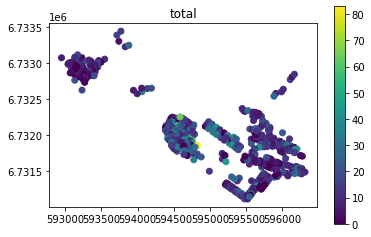

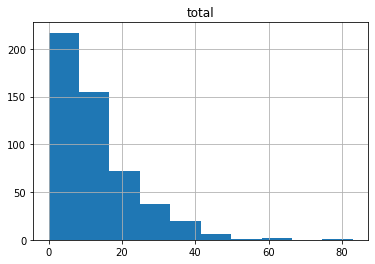

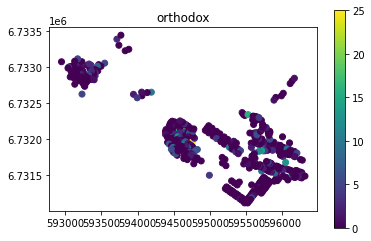

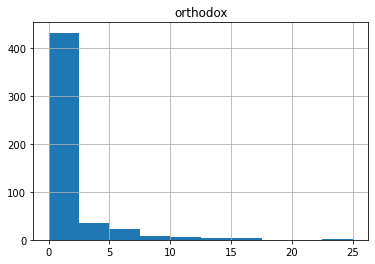

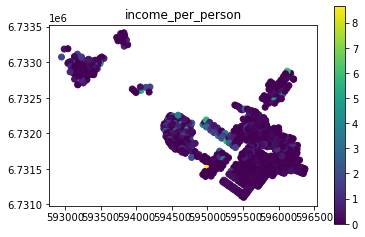

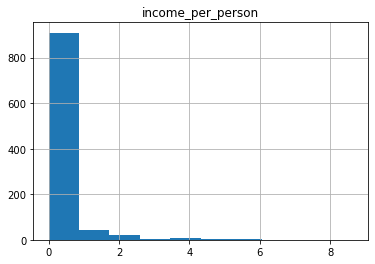

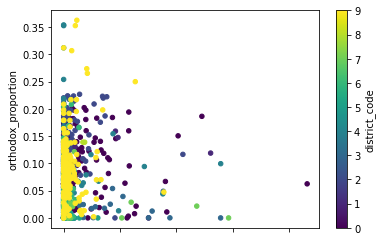

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

data = gpd.read_file('spatial_income_1880.shp')
data['orthodox_proportion'] = data.orthodox_d / data.total_dens
data['income_per_person'] = data.total_inco / data.total_dens
data.income_per_person = data.income_per_person.apply(lambda w: w if 0 <= w <= 10 else np.nan)

for c in 'total orthodox income_per_person'.split():
    data.plot(column=c, legend=True)
    plt.title(c)
    data.hist(c)

aspatial_data = pd.DataFrame(data, index=data.index)
aspatial_data['district_code'] = aspatial_data.district.factorize()[0]
aspatial_data.plot(x='income_per_person', y='orthodox_proportion', kind='scatter', c='district_code', colormap='viridis')
aspatial_data.to_csv('data.csv')


### Model description

Because the population variables are count data, I use Poisson distribution to model them.
Income data is often modelled using log-normal distribution, but in the case of 19th century tax system,
exponential distribution is more suitable.

$O_{k}$ and $P_k$ are the numbers of Eastern Orthodox and total population in location k, modeled with Poisson distributions.
$W_{k}$ is income per capita in location k, modeled with Exponential distribution.
$S$ is hypothetical non-income-related segregation, parametrized using mean and standard deviation.
$\bf\beta$ is the regression coefficient vector for use in Poisson regression. For simplicity, coefficients are assumed
to have normal distribution and there are no interactions between variables.

$ S \sim Beta(\mu=0.3, \sigma=0.1) $

$ W_k \sim Exp(0.5) $

$ P_k \sim Poisson(14) $

$ \bf\beta \sim N(\mu_{\beta}, \Sigma_{\beta}) $

$ \bf\mu_{\beta} = \begin{pmatrix} 0 & 0 & 0 & 0 \end{pmatrix}' $

$ \bf\Sigma_{\beta} = \begin{pmatrix} 0.25 & 0 & 0 & 0 \\ 0 & 0.25 & 0 & 0 \\ 0 & 0 & 0.25 & 0 \\ 0 & 0 & 0 & 0.25 \end{pmatrix} $

$ O_k \mid \bf\beta, W_k, P_k, S \sim Poisson(\mu_O) $

$ ln(\mu_O) = \beta_0 + \beta_1 W_k + \beta_2 P_k + \beta_3 S $

Joint probability of the model:
$ P(\beta, W_k, P_k, S, O_k) = P(S)P(W_k)P(P_k)P(\beta)P(O_k \mid S, W_k, P_k, \beta) $

### Inference Method

Hamiltonian Monte Carlo simulation is used to infer latent variables. The model is built using Python statistical inference library
[PyMC3](https://docs.pymc.io/) which implements (NUTS), which is a gradient-based Monte Carlo method.

## Experiment & Results

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, S]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 376.53draws/s]
The acceptance probability does not match the target. It is 0.8896927655805027, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8787527741395271, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 2000/2000 [00:04<00:00, 468.98it/s]
/home/antth/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/antth/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/data/io_py

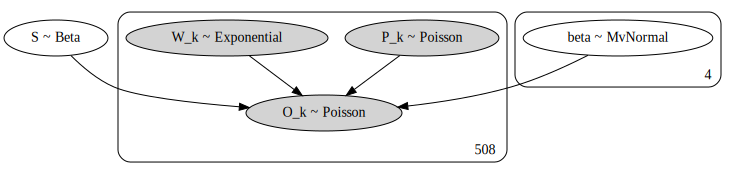

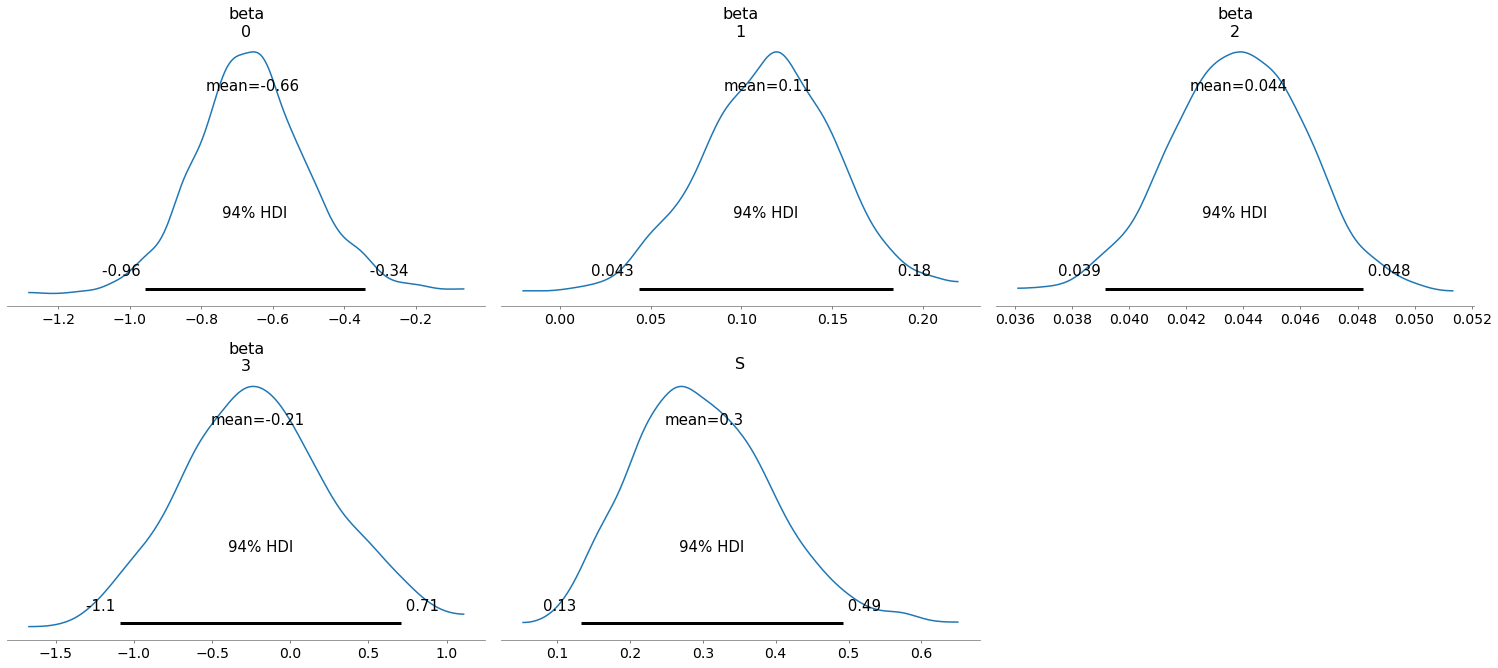

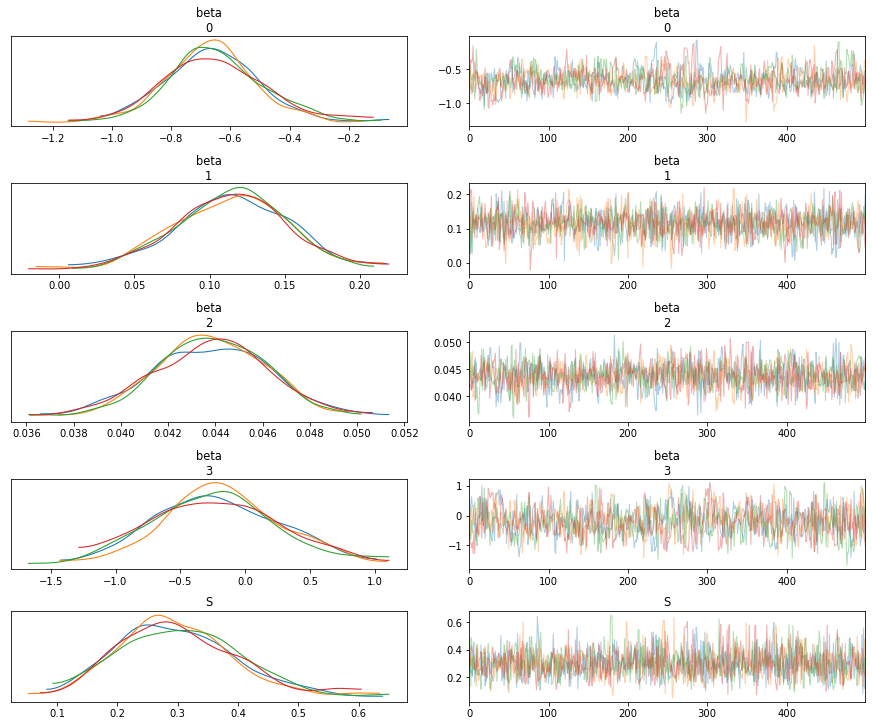

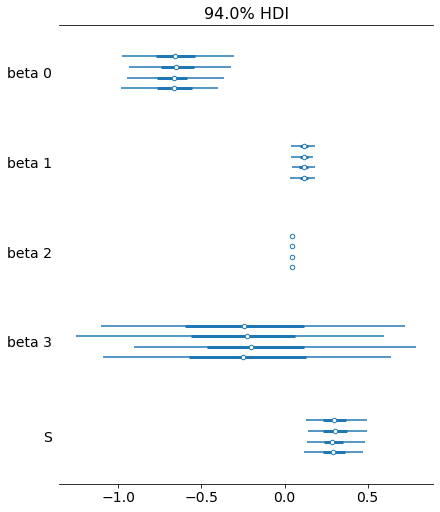

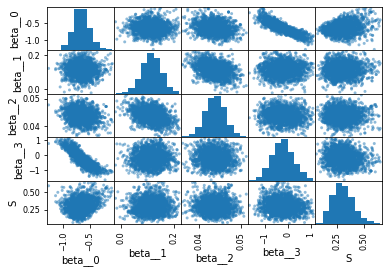

In [18]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

data = pd.read_csv('data.csv', index_col=0)
data = data.loc[:, 'total orthodox income_per_person'.split()].dropna(axis=0)

with pm.Model() as model:
    mu_S = 0.3
    sigma_S = 0.1
    S = pm.Beta('S', mu=mu_S, sigma=sigma_S)
    mu_W = 2
    lambda_W = 1/mu_W
    W_k = pm.Exponential('W_k', lambda_W, observed=data.income_per_person)
    mu_P = 14
    P_k = pm.Poisson('P_k', mu_P, observed=data.total)
    mu_beta = np.array([0., 0., 0., 0.])
    sigma_beta = np.array(np.diagflat([0.25, 0.25, 0.25, 0.25]))
    beta = pm.MvNormal('beta', mu_beta, sigma_beta, shape=4)
    mu_O = np.exp(beta[0] + beta[1] * W_k + beta[2] * P_k + beta[3] * S)
    alpha_O = 2
    O_k = pm.Poisson('O_k', mu_O, observed=data.orthodox)

    prior = pm.sample_prior_predictive()
    posterior = pm.sample(init="adapt_diag")
    posterior_prediction = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
az.plot_forest(posterior, combined=False, hdi_prob=0.94)
pd.plotting.scatter_matrix(pm.trace_to_dataframe(posterior))
pm.model_to_graphviz(model)

The most interesting latent variables analysed are S and $\beta_3$. The model gives almost no new information on their
distribution, so it can be concluded that there were no detectable non-income related segregation between Russians and
other population groups in Vyborg in 1880. The coefficients $\beta_1$ and $\beta_2$ are small but positive, as expected.

## Discussion and conclusion

The results do not indicate that there is a significant amount of segregation that would affect the distribution
of orthodox Russian Orthodox population apart from wealth and general population density.

However, more research is needed to determine whether there are differences between different districts of the city,
as these results could result from the ecological fallacy, i.e. the analysis results may depend on the spatial scale of
regression. One approach to studying the districts would be a hierarchical regression model with pooling of data.
In any case, the problem of spatial segregation involves interactions between many known and unknown
variables, and these kinds of problems must be studied using Bayesian multilevel models.

